### Importing Libraries

In [1]:
!pip install emoji
!pip install gensim
!pip install ray
!pip install wordcloud
!pip install tensorflow --quiet

  Using cached ray-2.48.0-cp312-cp312-manylinux2014_x86_64.whl.metadata (19 kB)
Using cached ray-2.48.0-cp312-cp312-manylinux2014_x86_64.whl (70.1 MB)


In [2]:
# Standard libraries
import os
import re
import string
import random
import warnings

# Suppress warnings for cleaner output
warnings.simplefilter('ignore')

# Data handling libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

# NLP preprocessing libraries
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Download required NLTK resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('universal_tagset')
nltk.download('omw-1.4')

# Machine learning libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                             classification_report, ConfusionMatrixDisplay)

# Deep learning libraries (PyTorch)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler

# Transformers for pre-trained language models (e.g., BERT)
import transformers
from transformers import BertTokenizer, BertModel

# Optional: Hyperparameter tuning libraries (advanced tuning support)
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.train import Checkpoint, get_checkpoint
import ray.cloudpickle as pickle
from functools import partial


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


###Data Loading and Exploration

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
folder_path = "/content/drive/MyDrive/Colab Notebooks/liar_dataset"
os.listdir(folder_path)

['train.tsv', 'valid.tsv', 'test.tsv', 'README', 'cleaned']

In [5]:
# Define column names based on LIAR documentation
column_names = [
    'id', 'label', 'statement', 'subject', 'speaker',
    'speaker_job_title', 'state_info', 'party_affiliation',
    'barely_true_counts', 'false_counts', 'half_true_counts',
    'mostly_true_counts', 'pants_on_fire_counts', 'context'
]

# Load all three official LIAR dataset splits
train_df = pd.read_csv(f"{folder_path}/train.tsv", sep='\t', names=column_names)
val_df = pd.read_csv(f"{folder_path}/valid.tsv", sep='\t', names=column_names)
test_df = pd.read_csv(f"{folder_path}/test.tsv", sep='\t', names=column_names)

# Quick shape check
print("Train:", train_df.shape)
print("Validation:", val_df.shape)
print("Test:", test_df.shape)


Train: (10240, 14)
Validation: (1284, 14)
Test: (1267, 14)


In [6]:
def check_missing_values(df, name):
    print(f"Missing values in {name}:")
    print(df.isnull().sum())
    print("-" * 50)

# Apply to all three
check_missing_values(train_df, "Train Set")
check_missing_values(val_df, "Validation Set")
check_missing_values(test_df, "Test Set")

Missing values in Train Set:
id                         0
label                      0
statement                  0
subject                    2
speaker                    2
speaker_job_title       2898
state_info              2210
party_affiliation          2
barely_true_counts         2
false_counts               2
half_true_counts           2
mostly_true_counts         2
pants_on_fire_counts       2
context                  102
dtype: int64
--------------------------------------------------
Missing values in Validation Set:
id                        0
label                     0
statement                 0
subject                   0
speaker                   0
speaker_job_title       345
state_info              279
party_affiliation         0
barely_true_counts        0
false_counts              0
half_true_counts          0
mostly_true_counts        0
pants_on_fire_counts      0
context                  12
dtype: int64
--------------------------------------------------
Missing val

In [7]:
# Check how many unique labels exist in the dataset
# View unique labels
print("Unique labels in the dataset:", train_df['label'].unique())

# Count each label
label_counts = train_df['label'].value_counts()
print("\nLabel distribution:\n", label_counts)

Unique labels in the dataset: ['false' 'half-true' 'mostly-true' 'true' 'barely-true' 'pants-fire']

Label distribution:
 label
half-true      2114
false          1995
mostly-true    1962
true           1676
barely-true    1654
pants-fire      839
Name: count, dtype: int64


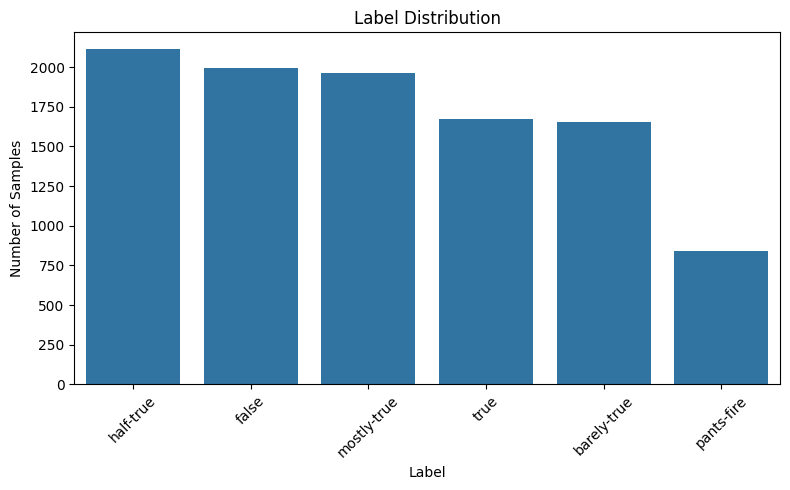

In [8]:
# Visualize distribution with bar plot
plt.figure(figsize=(8,5))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Label Distribution")
plt.ylabel("Number of Samples")
plt.xlabel("Label")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Data cleaning

In [9]:
def fill_missing_values(df):
    """
    Fills missing values in the LIAR dataset with logical replacements
    based on the column's context and type.
    """
    df['subject'] = df['subject'].fillna('miscellaneous')
    df['speaker'] = df['speaker'].fillna('anonymous')
    df['speaker_job_title'] = df['speaker_job_title'].fillna('no_official_title')
    df['state_info'] = df['state_info'].fillna('national')
    df['party_affiliation'] = df['party_affiliation'].fillna('independent')
    df['context'] = df['context'].fillna('casual remark')

    # Replace missing credibility counts with 0 (neutral value)
    credit_columns = [
        'barely_true_counts', 'false_counts', 'half_true_counts',
        'mostly_true_counts', 'pants_on_fire_counts'
    ]
    for col in credit_columns:
        df[col] = df[col].fillna(0)

    return df


In [10]:
train_df = fill_missing_values(train_df)
val_df = fill_missing_values(val_df)
test_df = fill_missing_values(test_df)

In [11]:
# Function to quickly check for missing values in any dataframe
def check_missing(df, name="DataFrame"):
    print(f"Missing values in {name}:")
    print(df.isnull().sum())
    print("-" * 50)

# Run for each split
check_missing(train_df, "Train Set")
check_missing(val_df, "Validation Set")
check_missing(test_df, "Test Set")

Missing values in Train Set:
id                      0
label                   0
statement               0
subject                 0
speaker                 0
speaker_job_title       0
state_info              0
party_affiliation       0
barely_true_counts      0
false_counts            0
half_true_counts        0
mostly_true_counts      0
pants_on_fire_counts    0
context                 0
dtype: int64
--------------------------------------------------
Missing values in Validation Set:
id                      0
label                   0
statement               0
subject                 0
speaker                 0
speaker_job_title       0
state_info              0
party_affiliation       0
barely_true_counts      0
false_counts            0
half_true_counts        0
mostly_true_counts      0
pants_on_fire_counts    0
context                 0
dtype: int64
--------------------------------------------------
Missing values in Test Set:
id                      0
label                   0
s

In [12]:
# Check for duplicates in each set
print("Duplicate rows in train set:", train_df.duplicated().sum())
print("Duplicate rows in val set:", val_df.duplicated().sum())
print("Duplicate rows in test set:", test_df.duplicated().sum())

Duplicate rows in train set: 0
Duplicate rows in val set: 0
Duplicate rows in test set: 0


In [13]:
# Check for any remaining NaN values
print("Missing values in training set:\n", train_df.isnull().sum())
print("\nMissing values in validation set:\n", val_df.isnull().sum())
print("\nMissing values in test set:\n", test_df.isnull().sum())

Missing values in training set:
 id                      0
label                   0
statement               0
subject                 0
speaker                 0
speaker_job_title       0
state_info              0
party_affiliation       0
barely_true_counts      0
false_counts            0
half_true_counts        0
mostly_true_counts      0
pants_on_fire_counts    0
context                 0
dtype: int64

Missing values in validation set:
 id                      0
label                   0
statement               0
subject                 0
speaker                 0
speaker_job_title       0
state_info              0
party_affiliation       0
barely_true_counts      0
false_counts            0
half_true_counts        0
mostly_true_counts      0
pants_on_fire_counts    0
context                 0
dtype: int64

Missing values in test set:
 id                      0
label                   0
statement               0
subject                 0
speaker                 0
speaker_job_title

#### Exploratory Data Analysis
This section explores the structure, distribution, and patterns in the LIAR dataset.
- We analyzed class distribution, statement lengths, and text patterns.
- We also generated word clouds to visualize frequent terms across truth labels.


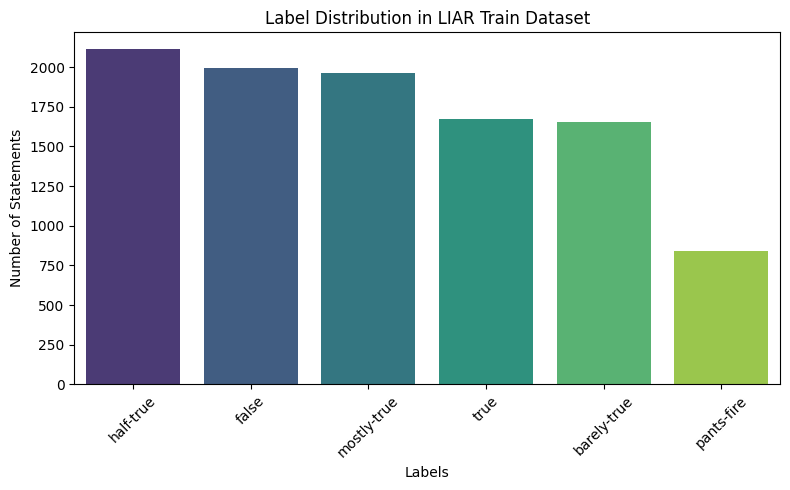

In [14]:
# Count occurrences of each label
label_counts = train_df['label'].value_counts()

# Bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")

plt.title("Label Distribution in LIAR Train Dataset")
plt.xlabel("Labels")
plt.ylabel("Number of Statements")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


count    10240.000000
mean        18.010059
std          9.658572
min          2.000000
25%         12.000000
50%         17.000000
75%         22.000000
max        467.000000
Name: statement_word_count, dtype: float64


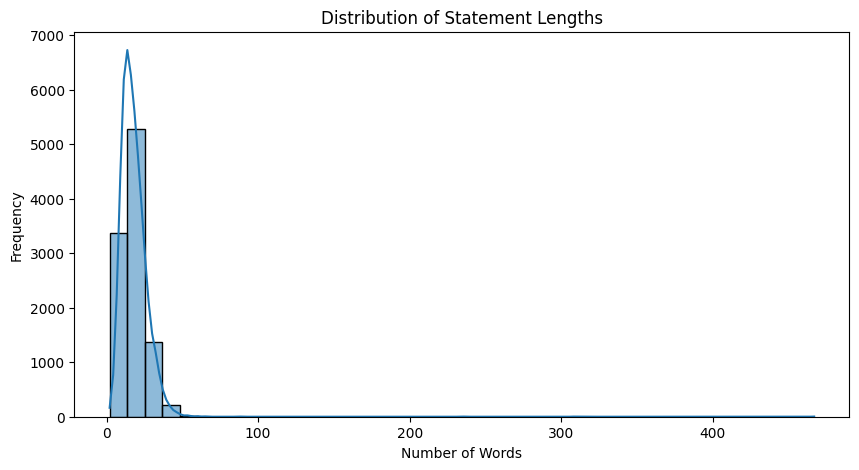

In [15]:
# Create a new column for number of words in each statement
train_df["statement_word_count"] = train_df["statement"].apply(lambda x: len(x.split()))

# Describe statistics
print(train_df["statement_word_count"].describe())

# Plot distribution of statement lengths
plt.figure(figsize=(10, 5))
sns.histplot(train_df["statement_word_count"], bins=40, kde=True)
plt.title("Distribution of Statement Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


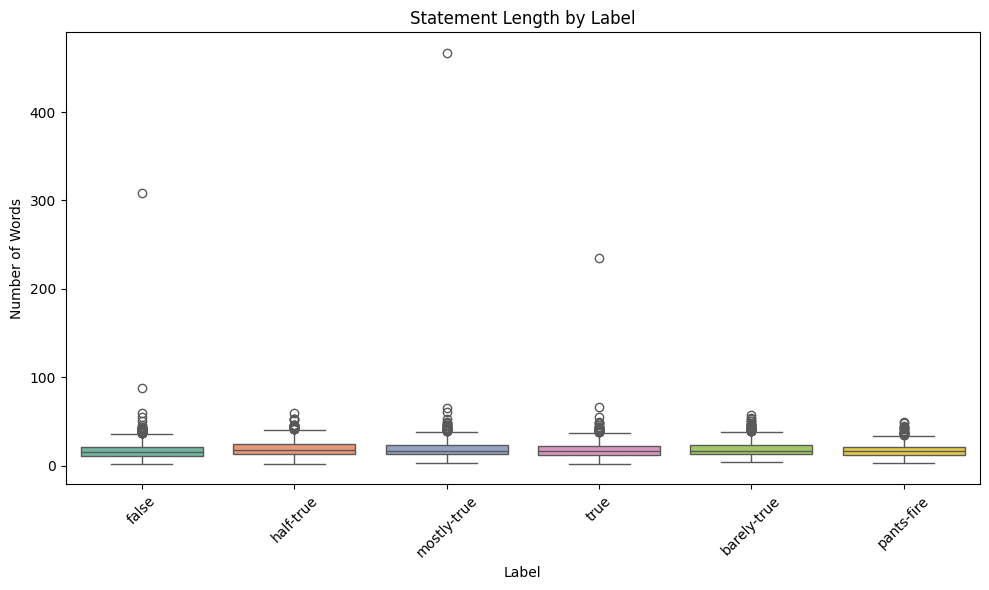

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df, x='label', y='statement_word_count', palette="Set2")
plt.title("Statement Length by Label")
plt.xlabel("Label")
plt.ylabel("Number of Words")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

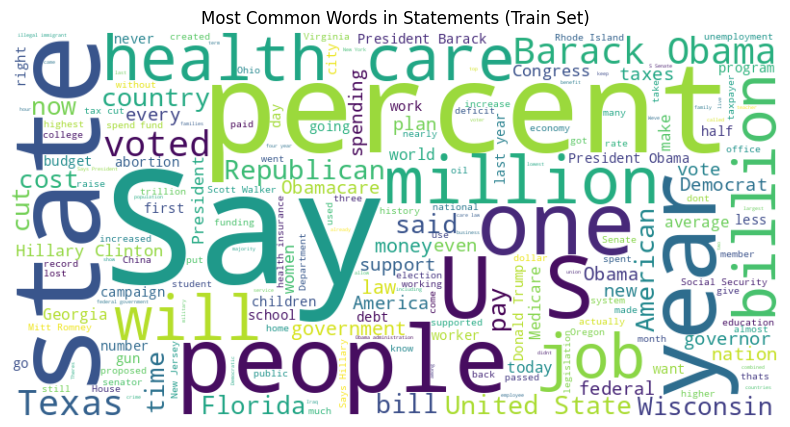

In [17]:
from wordcloud import WordCloud, STOPWORDS

# Combine all text
all_text = " ".join(train_df['statement'])

# Create word cloud
wordcloud = WordCloud(
    width=800, height=400,
    background_color='white',
    stopwords=STOPWORDS,
    max_words=200,
    colormap='viridis'
).generate(all_text)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Statements (Train Set)")
plt.show()


#### Text Preprocessing

Before feeding the text into our machine learning and deep learning models, I clean and normalize the text. This includes:
- Lowercasing
- Removing punctuation
- Removing stopwords
- Lemmatization

In [18]:
def clean_text_basic(text):
    """
    Cleans the input text by:
    - Lowercasing
    - Removing punctuation
    - Removing extra whitespace
    """
    text = text.lower()  # Lowercase all text
    text = re.sub(rf"[{re.escape(string.punctuation)}]", "", text)  # Remove punctuation
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra whitespace
    return text


In [19]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    """
    Removes English stopwords from the input text.
    """
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [20]:
def get_wordnet_pos(treebank_tag):
    """
    Converts POS tags from treebank to WordNet format.
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # default to noun


In [21]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    """
    Lemmatizes the input text using POS tagging.
    """
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    lemmatized_words = [
        lemmatizer.lemmatize(word, get_wordnet_pos(pos))
        for word, pos in pos_tags
    ]
    return " ".join(lemmatized_words)



In [22]:
# Apply all cleaning steps to each split
for df in [train_df, val_df, test_df]:
    df['cleaned_statement'] = df['statement'].apply(clean_text_basic)
    df['cleaned_statement'] = df['cleaned_statement'].apply(remove_stopwords)
    df['cleaned_statement'] = df['cleaned_statement'].apply(lemmatize_text)

In [23]:
# Check the result
train_df[['statement', 'cleaned_statement']].head()

,statement,cleaned_statement
0,Says the Annies List political group supports ...,say annies list political group support thirdt...
1,When did the decline of coal start? It started...,decline coal start start natural gas take star...
2,"Hillary Clinton agrees with John McCain ""by vo...",hillary clinton agree john mccain vote give ge...
3,Health care reform legislation is likely to ma...,health care reform legislation likely mandate ...
4,The economic turnaround started at the end of ...,economic turnaround start end term


In [24]:
# Define a new folder path to save the preprocessed files
save_path = "/content/drive/MyDrive/Colab Notebooks/liar_dataset/cleaned"

# Create the directory if it doesn't exist
import os
os.makedirs(save_path, exist_ok=True)

# Save each preprocessed split
train_df.to_csv(f"{save_path}/train_cleaned.csv", index=False)
val_df.to_csv(f"{save_path}/val_cleaned.csv", index=False)
test_df.to_csv(f"{save_path}/test_cleaned.csv", index=False)

#### Label Encoding
To prepare our target labels for machine learning models, we convert the categorical label column into numeric values using Label Encoding.
This is necessary because most models require numerical inputs for classification tasks.

In [25]:
from sklearn.preprocessing import LabelEncoder

# Initialize encoder and fit ONLY on training labels
label_encoder = LabelEncoder()
label_encoder.fit(train_df['label'])

# Apply the fitted encoder to all splits
train_df['label_encoded'] = label_encoder.transform(train_df['label'])
val_df['label_encoded'] = label_encoder.transform(val_df['label'])
test_df['label_encoded'] = label_encoder.transform(test_df['label'])

# Create a mapping dictionary for reference
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

# Preview encoded labels in train set
train_df[['label', 'label_encoded']].head()


Label Mapping: {'barely-true': 0, 'false': 1, 'half-true': 2, 'mostly-true': 3, 'pants-fire': 4, 'true': 5}


,label,label_encoded
0,false,1
1,half-true,2
2,mostly-true,3
3,false,1
4,half-true,2


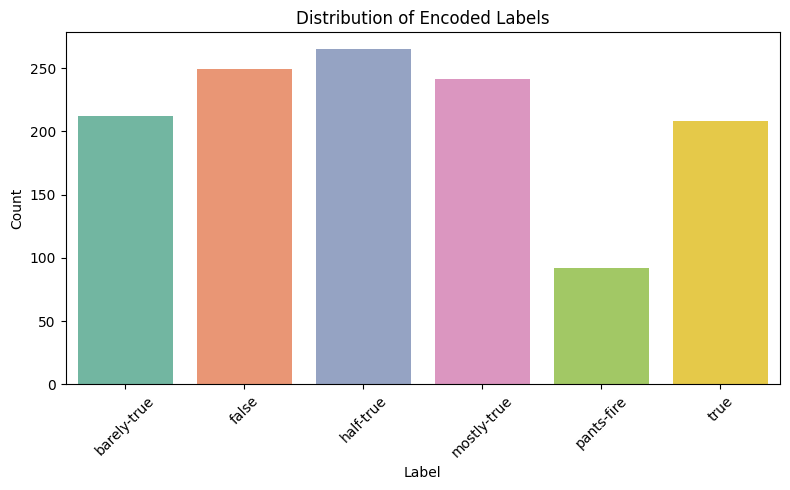

In [26]:
# Plot distribution of encoded labels
plt.figure(figsize=(8, 5))
sns.countplot(x='label_encoded', data=df, palette='Set2')

# Add label names as x-ticks for clarity
plt.xticks(ticks=range(len(label_mapping)), labels=label_mapping.keys(), rotation=45)
plt.title('Distribution of Encoded Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

#### Class Balance Analysis and Weight Calculation

We examine the distribution of class labels in the training set to check for class imbalance.
This helps determine whether resampling strategies (e.g., oversampling, undersampling, or class weights) may be necessary to improve model performance and avoid bias toward majority classes.
To address the class imbalance observed in the training dataset, we computed class weights. These weights will later be used in model training to ensure that minority classes receive appropriate attention during optimization.





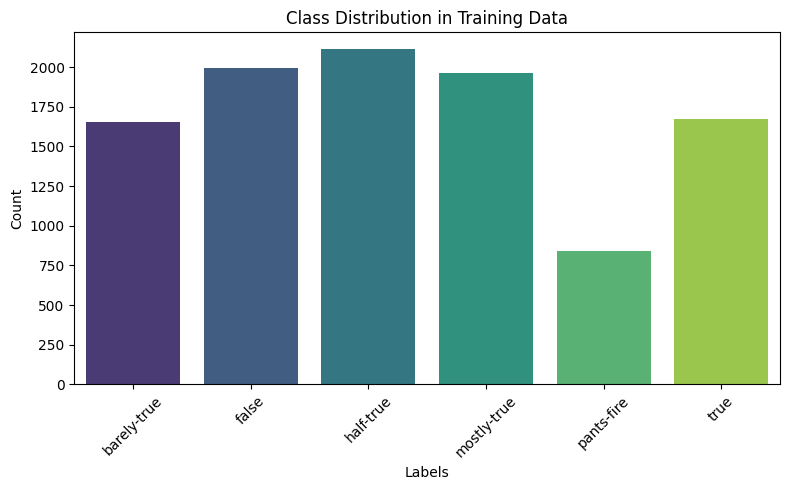

In [27]:
# Visualize class distribution in training data
plt.figure(figsize=(8, 5))
sns.countplot(x='label_encoded', data=train_df, palette='viridis')

# Add label names to x-ticks for clarity
plt.xticks(
    ticks=range(len(label_mapping)),
    labels=label_mapping.keys(),
    rotation=45
)
plt.title('Class Distribution in Training Data')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [28]:
# Raw counts
class_counts = train_df['label_encoded'].value_counts().sort_index()
print("Class Counts:\n", class_counts)

# Proportions
class_proportions = class_counts / len(train_df)
print("\nClass Proportions:\n", class_proportions)

Class Counts:
 label_encoded
0    1654
1    1995
2    2114
3    1962
4     839
5    1676
Name: count, dtype: int64

Class Proportions:
 label_encoded
0    0.161523
1    0.194824
2    0.206445
3    0.191602
4    0.081934
5    0.163672
Name: count, dtype: float64


In [29]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Extract the training labels
train_labels = train_df['label_encoded'].values

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_labels),
                                     y=train_labels)

# Convert to dictionary: {class_index: weight}
class_weight_dict = {i : weight for i, weight in enumerate(class_weights)}

# Display the result
print("Class Weights:\n", class_weight_dict)


Class Weights:
 {0: 1.0318419991938734, 1: 0.8554720133667502, 2: 0.8073163040050457, 3: 0.8698606863744478, 4: 2.0341676599125944, 5: 1.0182975338106603}


### Traditional Classifiers

#### Baseline Classifier (Naive Prediction using Majority Class)

Before training real machine learning models, it is useful to establish a baseline. A baseline classifier helps evaluate whether our trained models actually learn meaningful patterns or just benefit from class imbalances.

Here, we define a simple classifier that always predicts the majority class from the training set. This will give us reference metrics (accuracy, precision, recall, F1-score) to compare with real models.


In [30]:
# Use the predefined splits
X_train = train_df['cleaned_statement']
y_train = train_df['label_encoded']

X_val = val_df['cleaned_statement']
y_val = val_df['label_encoded']

X_test = test_df['cleaned_statement']
y_test = test_df['label_encoded']

Majority class in training set: 2
Classification Report for Baseline Classifier (Majority Class Only):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       212
           1       0.00      0.00      0.00       249
           2       0.21      1.00      0.35       265
           3       0.00      0.00      0.00       241
           4       0.00      0.00      0.00        92
           5       0.00      0.00      0.00       208

    accuracy                           0.21      1267
   macro avg       0.03      0.17      0.06      1267
weighted avg       0.04      0.21      0.07      1267



<Figure size 800x600 with 0 Axes>

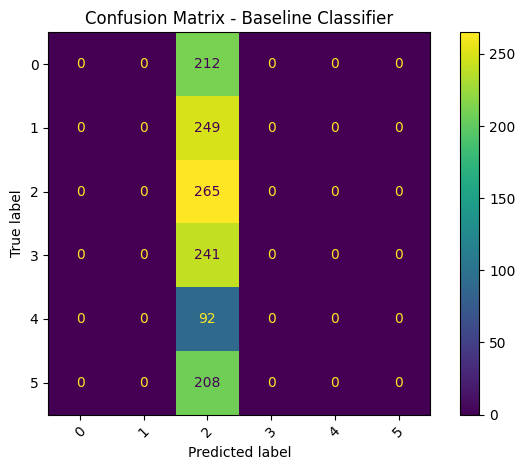

In [31]:
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Step 1: Find the majority class in the training labels
majority_class = Counter(y_train).most_common(1)[0][0]
print(f"Majority class in training set: {majority_class}")

# Step 2: Predict this class for all test samples
baseline_preds = [majority_class] * len(y_test)

# Step 3: Print classification report
print("Classification Report for Baseline Classifier (Majority Class Only):")
print(classification_report(y_test, baseline_preds))

# Step 4: Visualize Confusion Matrix
cm = confusion_matrix(y_test, baseline_preds, labels=sorted(np.unique(y_train)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(np.unique(y_train)))

plt.figure(figsize=(8,6))
disp.plot(cmap='viridis', xticks_rotation=45)
plt.title("Confusion Matrix - Baseline Classifier")
plt.grid(False)
plt.tight_layout()
plt.show()


#### TF-IDF Vectorization

TF-IDF (Term Frequency-Inverse Document Frequency) helps us convert text into numerical vectors by measuring how important a word is in a document relative to the entire corpus. Words that are common across many documents are down-weighted.

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,     # Limit vocabulary size (you can adjust this)
    ngram_range=(1, 2),     # Use unigrams and bigrams
    stop_words='english'   # Remove common stopwords
)

# Fit on training data and transform all splits
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Check shapes
print("TF-IDF Train Shape:", X_train_tfidf.shape)
print("TF-IDF Validation Shape:", X_val_tfidf.shape)
print("TF-IDF Test Shape:", X_test_tfidf.shape)


TF-IDF Train Shape: (10240, 5000)
TF-IDF Validation Shape: (1284, 5000)
TF-IDF Test Shape: (1267, 5000)


#### Logistic Regression with TF-IDF

In this section, we train a Logistic Regression model using TF-IDF vectorized features. Logistic Regression is a widely used traditional machine learning algorithm for classification tasks, known for its efficiency and interpretability.

To address class imbalance, we incorporate class weights. We evaluate the model’s performance on the validation set using a classification report and a confusion matrix.

Classification Report - Logistic Regression:
              precision    recall  f1-score   support

           0       0.23      0.20      0.21       237
           1       0.24      0.19      0.21       263
           2       0.26      0.21      0.23       248
           3       0.28      0.26      0.27       251
           4       0.22      0.38      0.28       116
           5       0.19      0.27      0.22       169

    accuracy                           0.24      1284
   macro avg       0.24      0.25      0.24      1284
weighted avg       0.24      0.24      0.24      1284



<Figure size 800x600 with 0 Axes>

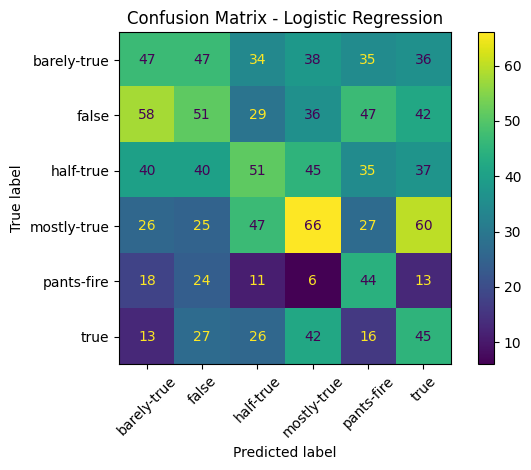

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Initialize the classifier
logreg_model = LogisticRegression(max_iter=1000, class_weight=class_weight_dict, random_state=42)

# Train the model
logreg_model.fit(X_train_tfidf, y_train)

# Predict on validation set
logreg_preds = logreg_model.predict(X_val_tfidf)

# Classification Report
print("Classification Report - Logistic Regression:")
print(classification_report(y_val, logreg_preds))

# Confusion Matrix
cm = confusion_matrix(y_val, logreg_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_mapping.keys())

plt.figure(figsize=(8, 6))
disp.plot(cmap='viridis', xticks_rotation=45)
plt.title("Confusion Matrix - Logistic Regression")
plt.grid(False)
plt.tight_layout()
plt.show()


#### Support Vector Machine (SVM) Classifier

We trained a LinearSVC model on TF-IDF features to classify political fake news. To handle class imbalance, we applied class_weight='balanced'.
Performance was evaluated on the validation set using standard classification metrics

SVM Classifier Evaluation:
              precision    recall  f1-score   support

           0       0.24      0.22      0.23       237
           1       0.21      0.19      0.20       263
           2       0.21      0.19      0.20       248
           3       0.27      0.25      0.26       251
           4       0.22      0.28      0.24       116
           5       0.20      0.27      0.23       169

    accuracy                           0.23      1284
   macro avg       0.22      0.23      0.23      1284
weighted avg       0.23      0.23      0.22      1284



<Figure size 800x600 with 0 Axes>

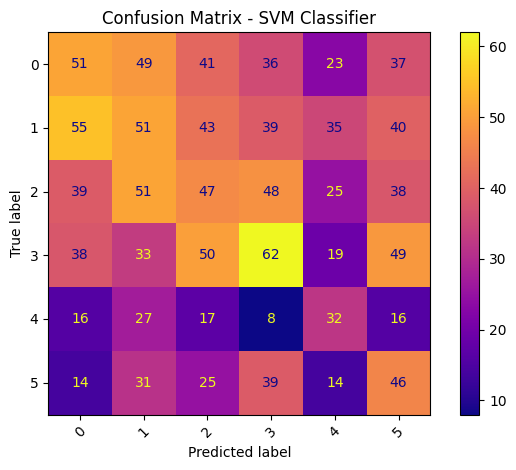

In [34]:
from sklearn.svm import LinearSVC

# Define the model with class weights
svm_model = LinearSVC(class_weight='balanced', random_state=42)

# Train the model
svm_model.fit(X_train_tfidf, y_train)

# Predict on the validation set
svm_preds = svm_model.predict(X_val_tfidf)

# Evaluate performance
print("SVM Classifier Evaluation:")
print(classification_report(y_val, svm_preds))

# Plot confusion matrix
cm = confusion_matrix(y_val, svm_preds, labels=sorted(np.unique(y_train)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(np.unique(y_train)))

plt.figure(figsize=(8,6))
disp.plot(cmap='plasma', xticks_rotation=45)
plt.title("Confusion Matrix - SVM Classifier")
plt.grid(False)
plt.tight_layout()
plt.show()


#### TF-IDF + Random Forest Classifier

 Classification Report – Random Forest:
              precision    recall  f1-score   support

           0       0.26      0.17      0.21       237
           1       0.29      0.35      0.32       263
           2       0.22      0.26      0.24       248
           3       0.30      0.36      0.32       251
           4       0.27      0.16      0.20       116
           5       0.26      0.21      0.23       169

    accuracy                           0.27      1284
   macro avg       0.27      0.25      0.25      1284
weighted avg       0.27      0.27      0.26      1284



<Figure size 800x600 with 0 Axes>

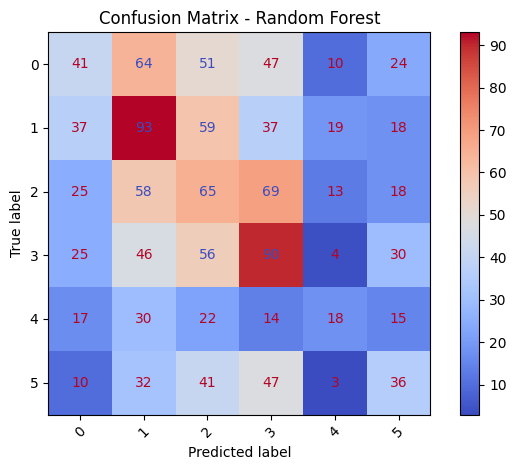

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Define the model
rf_model = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)

# 2. Train the model
rf_model.fit(X_train_tfidf, y_train)

# 3. Predict on validation set
rf_preds = rf_model.predict(X_val_tfidf)

# 4. Classification Report
print(" Classification Report – Random Forest:")
print(classification_report(y_val, rf_preds))

# 5. Confusion Matrix
cm = confusion_matrix(y_val, rf_preds, labels=sorted(np.unique(y_train)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(np.unique(y_train)))

plt.figure(figsize=(8, 6))
disp.plot(cmap='coolwarm', xticks_rotation=45)
plt.title("Confusion Matrix - Random Forest")
plt.grid(False)
plt.tight_layout()
plt.show()


#### Multinomial Naive Bayes Classifier

We apply the Multinomial Naive Bayes (MNB) algorithm, which is well-suited for text classification tasks involving word frequencies and TF-IDF features. This model assumes that features follow a multinomial distribution and works effectively with discrete data like word counts or TF-IDF values.

Classification Report — Multinomial Naive Bayes:
              precision    recall  f1-score   support

           0       0.24      0.11      0.15       237
           1       0.26      0.37      0.31       263
           2       0.22      0.35      0.27       248
           3       0.27      0.31      0.29       251
           4       0.17      0.01      0.02       116
           5       0.19      0.12      0.15       169

    accuracy                           0.24      1284
   macro avg       0.22      0.21      0.20      1284
weighted avg       0.23      0.24      0.22      1284



<Figure size 800x600 with 0 Axes>

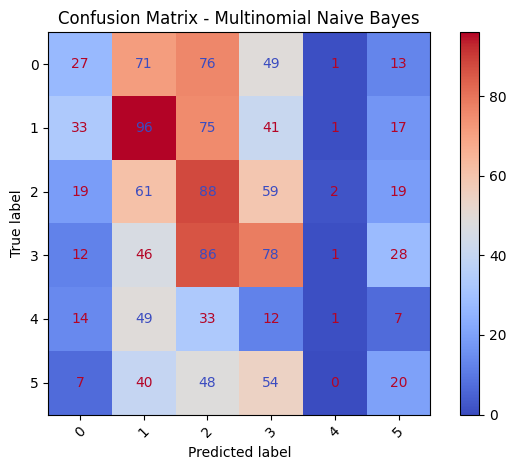

In [36]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Define and train the model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# 2. Predict on the validation set
nb_preds = nb_model.predict(X_val_tfidf)

# 3. Classification report
print("Classification Report — Multinomial Naive Bayes:")
print(classification_report(y_val, nb_preds))

# 4. Confusion matrix
cm = confusion_matrix(y_val, nb_preds, labels=sorted(np.unique(y_train)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(np.unique(y_train)))

plt.figure(figsize=(8, 6))
disp.plot(cmap='coolwarm', xticks_rotation=45)
plt.title("Confusion Matrix - Multinomial Naive Bayes")
plt.grid(False)
plt.tight_layout()
plt.show()


#### LSTM Model for Multi-class Classification

In [37]:
from tensorflow.keras.preprocessing.text import Tokenizer # Import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences # Import pad_sequences

# Prepare tokenizer on training data
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['cleaned_statement'])

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(train_df['cleaned_statement'])
X_val_seq = tokenizer.texts_to_sequences(val_df['cleaned_statement'])
X_test_seq = tokenizer.texts_to_sequences(test_df['cleaned_statement'])

# Pad sequences to the same length
max_length = max(len(x) for x in X_train_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# Target labels
y_train = train_df['label_encoded']
y_val = val_df['label_encoded']
y_test = test_df['label_encoded']

In [38]:
from tensorflow.keras.models import Sequential # Import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout # Import necessary layers

# Define input size
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128
num_classes = len(np.unique(y_train))

# Build the LSTM model
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile model
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

lstm_model.build(input_shape=(None, max_length))


# Show model summary
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 344, 128)       │     1,399,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,453,894 (5.55 MB)

 Trainable params: 1,453,894 (5.55 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

history = lstm_model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/15
320/320 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.1926 - loss: 1.7703 - val_accuracy: 0.1931 - val_loss: 1.7633
Epoch 2/15
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.2006 - loss: 1.7571 - val_accuracy: 0.1931 - val_loss: 1.7620
Epoch 3/15
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.2005 - loss: 1.7631 - val_accuracy: 0.1931 - val_loss: 1.7641
Epoch 4/15
320/320 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.1950 - loss: 1.7605 - val_accuracy: 0.1931 - val_loss: 1.7628


## Switching from Multiclass to Binary Classification

### Simplifying to Binary Classification

After testing several models (Logistic Regression, SVM, Random Forest, Naive Bayes, LSTM), the multiclass setup didn’t perform well. The models struggled to tell similar labels apart and adjusting for class imbalance didn’t help much.

To improve results, we're simplifying the task:  
- Grouping false, barely-true, pants-fire as **Fake (0)**  
- Grouping true, mostly-true, half-true as **Real (1)**

This binary setup is more practical and has been used successfully in other fake news studies.


In [40]:
# Define a function to map original 6-class labels to binary classes
def convert_to_binary(label):
    """
    Converts multiclass label into binary:
    - Returns 1 (REAL) for labels: 2 = half-true, 3 = mostly-true, 5 = true
    - Returns 0 (FAKE) for labels: 0 = pants-fire, 1 = false, 4 = barely-true
    """
    return 1 if label in [2, 3, 5] else 0

# Apply the binary conversion to each dataset split
for df in [train_df, val_df, test_df]:
    df['binary_label'] = df['label_encoded'].apply(convert_to_binary)

# Check class distribution in the training set after conversion
print(train_df['binary_label'].value_counts())


binary_label
1    5752
0    4488
Name: count, dtype: int64


In [41]:
X_train = train_df['cleaned_statement']
y_train = train_df['binary_label']

X_val = val_df['cleaned_statement']
y_val = val_df['binary_label']

X_test = test_df['cleaned_statement']
y_test = test_df['binary_label']


### Traditional Classifiers

#### Baseline Binary Classifier

To establish a baseline for comparison, we create a simple model that always predicts the majority class in the training set. This helps us understand the minimum performance a real model should improve upon.


Majority class in training set: 1
Classification Report — Baseline Classifier:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       553
           1       0.56      1.00      0.72       714

    accuracy                           0.56      1267
   macro avg       0.28      0.50      0.36      1267
weighted avg       0.32      0.56      0.41      1267



<Figure size 600x500 with 0 Axes>

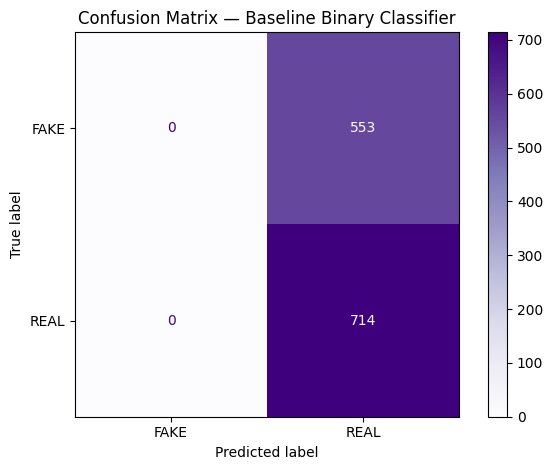

In [42]:
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Identify the majority class in the training labels
majority_class = Counter(y_train).most_common(1)[0][0]
print(f"Majority class in training set: {majority_class}")

# Step 2: Predict the majority class for all test samples
baseline_preds = [majority_class] * len(y_test)

# Step 3: Evaluation metrics
print("Classification Report — Baseline Classifier:")
print(classification_report(y_test, baseline_preds))

# Step 4: Confusion Matrix
cm = confusion_matrix(y_test, baseline_preds, labels=sorted(np.unique(y_train)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FAKE', 'REAL'])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Purples', xticks_rotation=0)
plt.title("Confusion Matrix — Baseline Binary Classifier")
plt.grid(False)
plt.tight_layout()
plt.show()

#### TF-IDF Vectorization with N-grams (for Binary Classification)

To prepare our text data for model training, we apply **TF-IDF vectorization** using both unigrams and bigrams (ngram_range=(1, 2)), allowing the model to capture individual words and short phrases.

- The vectorizer is limited to the top 5,000 most informative features.
- It is fitted on the training set and used to transform the validation and test sets.
- This setup uses our binary classification labels:
  - 0 → **FAKE** (false, barely-true, pants-fire)
  - 1 → **REAL** (true, mostly-true, half-true)

This transformation produces consistent numeric input across all models.


In [43]:
# Initialize TF-IDF Vectorizer with unigrams + bigrams
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)

# Fit on training data and transform all splits
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['cleaned_statement'])
X_val_tfidf   = tfidf_vectorizer.transform(val_df['cleaned_statement'])
X_test_tfidf  = tfidf_vectorizer.transform(test_df['cleaned_statement'])

# Targets for binary classification
y_train_bin = train_df['binary_label']
y_val_bin   = val_df['binary_label']
y_test_bin  = test_df['binary_label']

# Shape check
print("TF-IDF Train Shape:", X_train_tfidf.shape)
print("TF-IDF Validation Shape:", X_val_tfidf.shape)
print("TF-IDF Test Shape:", X_test_tfidf.shape)


TF-IDF Train Shape: (10240, 5000)
TF-IDF Validation Shape: (1284, 5000)
TF-IDF Test Shape: (1267, 5000)


#### Logistic Regression (Binary Classification)

We begin training our binary classification models using TF-IDF vectorized features. The first model tested is **Logistic Regression**, a strong and interpretable baseline.

This model predicts whether a political statement is **FAKE (0)** or **REAL (1)** based on its TF-IDF representation.


Classification Report — Logistic Regression:
              precision    recall  f1-score   support

        FAKE       0.61      0.62      0.61       616
        REAL       0.64      0.64      0.64       668

    accuracy                           0.63      1284
   macro avg       0.63      0.63      0.63      1284
weighted avg       0.63      0.63      0.63      1284



<Figure size 600x500 with 0 Axes>

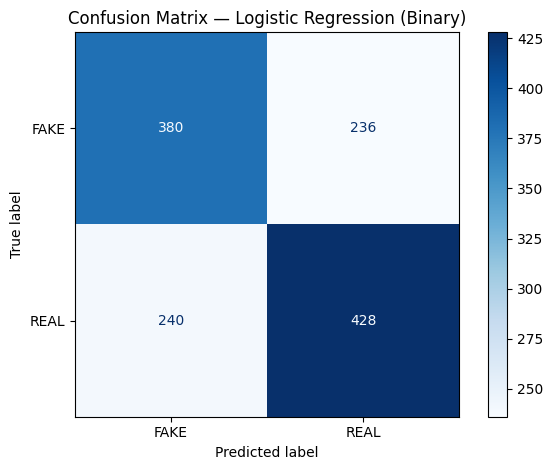

In [44]:
# 1. Define and train the model
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_model.fit(X_train_tfidf, y_train_bin)

# 2. Predict on the validation set
lr_preds = lr_model.predict(X_val_tfidf)

# 3. Classification report
print("Classification Report — Logistic Regression:")
print(classification_report(y_val_bin, lr_preds, target_names=['FAKE', 'REAL']))

# 4. Confusion matrix
cm = confusion_matrix(y_val_bin, lr_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FAKE', 'REAL'])

plt.figure(figsize=(6, 5))
disp.plot(cmap="Blues", xticks_rotation=0)
plt.title("Confusion Matrix — Logistic Regression (Binary)")
plt.grid(False)
plt.tight_layout()
plt.show()

#### Support Vector Machine (Binary Classification)

Next, we train a Support Vector Machine (SVM) model using the binary-labeled TF-IDF features. SVMs are powerful classifiers that perform well on text classification tasks, especially when using high-dimensional sparse inputs like TF-IDF.


Classification Report — SVM (Binary):
              precision    recall  f1-score   support

        FAKE       0.60      0.59      0.60       616
        REAL       0.63      0.64      0.63       668

    accuracy                           0.62      1284
   macro avg       0.62      0.62      0.62      1284
weighted avg       0.62      0.62      0.62      1284



<Figure size 600x500 with 0 Axes>

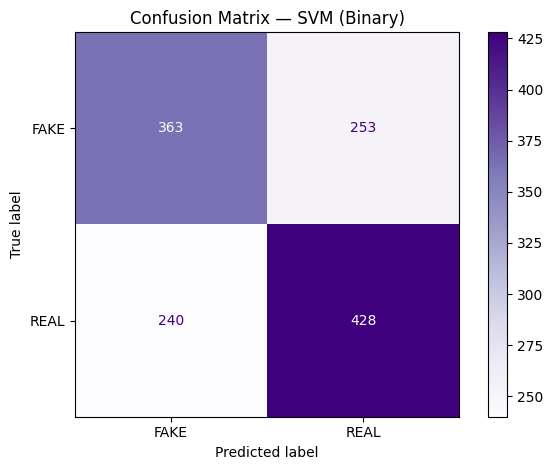

In [45]:
from sklearn.svm import LinearSVC

# 1. Define and train the model
svm_model = LinearSVC(class_weight='balanced', random_state=42)
svm_model.fit(X_train_tfidf, y_train_bin)

# 2. Predict on the validation set
svm_preds = svm_model.predict(X_val_tfidf)

# 3. Classification report
print("Classification Report — SVM (Binary):")
print(classification_report(y_val_bin, svm_preds, target_names=['FAKE', 'REAL']))

# 4. Confusion matrix
cm = confusion_matrix(y_val_bin, svm_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FAKE', 'REAL'])

plt.figure(figsize=(6, 5))
disp.plot(cmap="Purples", xticks_rotation=0)
plt.title("Confusion Matrix — SVM (Binary)")
plt.grid(False)
plt.tight_layout()
plt.show()


#### Random Forest (Binary Classification)

We now train a Random Forest classifier using TF-IDF features for binary fake news detection. This ensemble method combines multiple decision trees to improve robustness and reduce overfitting.


Classification Report — Random Forest (Binary):
              precision    recall  f1-score   support

        FAKE       0.64      0.56      0.60       616
        REAL       0.64      0.71      0.67       668

    accuracy                           0.64      1284
   macro avg       0.64      0.63      0.63      1284
weighted avg       0.64      0.64      0.63      1284



<Figure size 600x500 with 0 Axes>

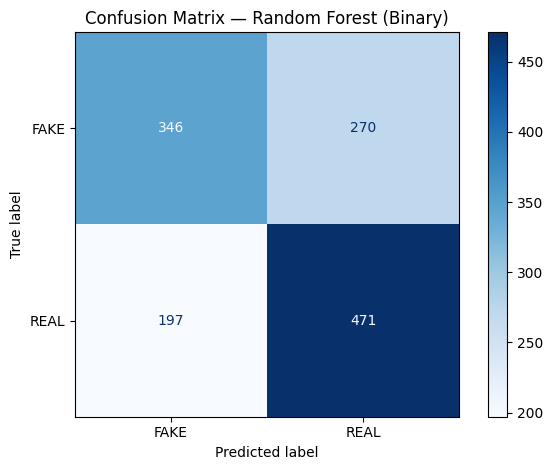

In [46]:
from sklearn.ensemble import RandomForestClassifier

# 1. Define and train the model
rf_model = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train_bin)

# 2. Predict on the validation set
rf_preds = rf_model.predict(X_val_tfidf)

# 3. Classification report
print("Classification Report — Random Forest (Binary):")
print(classification_report(y_val_bin, rf_preds, target_names=['FAKE', 'REAL']))

# 4. Confusion matrix
cm = confusion_matrix(y_val_bin, rf_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FAKE', 'REAL'])

plt.figure(figsize=(6, 5))
disp.plot(cmap="Blues", xticks_rotation=0)
plt.title("Confusion Matrix — Random Forest (Binary)")
plt.grid(False)
plt.tight_layout()
plt.show()


#### Multinomial Naive Bayes for Fake News Detection (Binary Classification)

We now apply the Multinomial Naive Bayes classifier on the binary-labeled TF-IDF features.


Classification Report — Multinomial Naive Bayes (Binary):
              precision    recall  f1-score   support

        FAKE       0.65      0.45      0.53       616
        REAL       0.61      0.78      0.68       668

    accuracy                           0.62      1284
   macro avg       0.63      0.61      0.61      1284
weighted avg       0.63      0.62      0.61      1284



<Figure size 600x500 with 0 Axes>

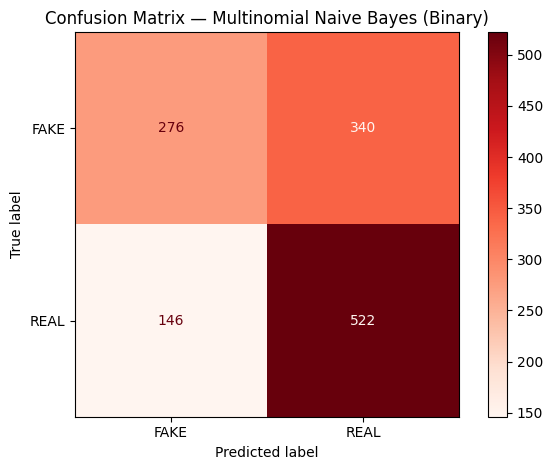

In [47]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1. Train the model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train_bin)

# 2. Predict on validation set
nb_preds = nb_model.predict(X_val_tfidf)

# 3. Classification Report
print("Classification Report — Multinomial Naive Bayes (Binary):")
print(classification_report(y_val_bin, nb_preds, target_names=['FAKE', 'REAL']))

# 4. Confusion Matrix
cm = confusion_matrix(y_val_bin, nb_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FAKE', 'REAL'])

plt.figure(figsize=(6, 5))
disp.plot(cmap="Reds", xticks_rotation=0)
plt.title("Confusion Matrix — Multinomial Naive Bayes (Binary)")
plt.grid(False)
plt.tight_layout()
plt.show()

#### Hybrid RFSVM Model (Random Forest + SVM)

To improve classification performance, we implemented a hybrid model inspired by the paper *"Hybrid RFSVM: Hybridization of SVM and Random Forest Models for Detection of Fake News"*

- **Step 1:** Random Forest is trained on the TF-IDF features.
- **Step 2:** The model outputs class probabilities as features.
- **Step 3:** An SVM is trained on these RF-generated probabilities.
- **Step 4:** Performance is evaluated on the validation set.

This ensemble aims to combine the robustness of Random Forest with the margin-optimization of SVM.


Classification Report — Hybrid RFSVM Model:
              precision    recall  f1-score   support

        FAKE       0.64      0.56      0.60       616
        REAL       0.64      0.71      0.67       668

    accuracy                           0.64      1284
   macro avg       0.64      0.63      0.63      1284
weighted avg       0.64      0.64      0.63      1284



<Figure size 600x500 with 0 Axes>

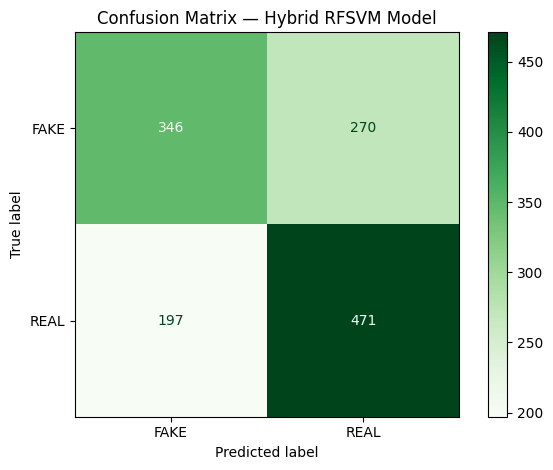

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1. Train the Random Forest model to get probability features
rf_base = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_base.fit(X_train_tfidf, y_train_bin)

# 2. Extract probabilistic features from RF (probability estimates)
X_train_rf_probs = rf_base.predict_proba(X_train_tfidf)
X_val_rf_probs = rf_base.predict_proba(X_val_tfidf)

# 3. Train SVM on RF's output probabilities
svm_hybrid = SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42)
svm_hybrid.fit(X_train_rf_probs, y_train_bin)

# 4. Predict on the validation set
svm_preds = svm_hybrid.predict(X_val_rf_probs)

# 5. Evaluation
print("Classification Report — Hybrid RFSVM Model:")
print(classification_report(y_val_bin, svm_preds, target_names=['FAKE', 'REAL']))

# 6. Confusion Matrix
cm = confusion_matrix(y_val_bin, svm_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FAKE', 'REAL'])

plt.figure(figsize=(6, 5))
disp.plot(cmap="Greens", xticks_rotation=0)
plt.title("Confusion Matrix — Hybrid RFSVM Model")
plt.grid(False)
plt.tight_layout()
plt.show()


#### Hyperparameter Tuning — Logistic Regression (Binary Classification)

To further improve performance, we perform hyperparameter tuning on our Logistic Regression model using GridSearchCV.

This approach tests multiple combinations of parameters such as:
- C: Regularization strength
- penalty: Type of regularization
- solver: Optimization algorithm

We use cross-validation to select the best performing combination based on validation performance.


Best Hyperparameters:
 {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}

Classification Report — Logistic Regression (Tuned):
              precision    recall  f1-score   support

        FAKE       0.61      0.64      0.62       616
        REAL       0.65      0.62      0.63       668

    accuracy                           0.63      1284
   macro avg       0.63      0.63      0.63      1284
weighted avg       0.63      0.63      0.63      1284



<Figure size 600x500 with 0 Axes>

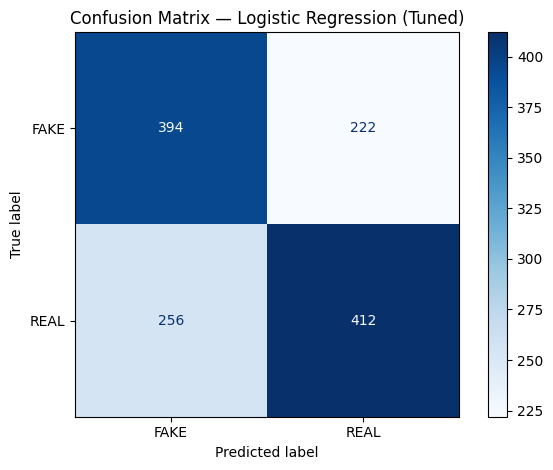

In [49]:
# Define the hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': ['balanced']
}

# Initialize the model
lr_base = LogisticRegression(max_iter=1000, random_state=42)

# Perform grid search
grid_search = GridSearchCV(estimator=lr_base, param_grid=param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train_tfidf, y_train_bin)

# Best model
best_lr = grid_search.best_estimator_
print("Best Hyperparameters:\n", grid_search.best_params_)

# Evaluate on validation set
lr_preds = best_lr.predict(X_val_tfidf)

# Print report
print("\nClassification Report — Logistic Regression (Tuned):")
print(classification_report(y_val_bin, lr_preds, target_names=['FAKE', 'REAL']))

# Plot confusion matrix
cm = confusion_matrix(y_val_bin, lr_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FAKE', 'REAL'])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', xticks_rotation=0)
plt.title("Confusion Matrix — Logistic Regression (Tuned)")
plt.grid(False)
plt.tight_layout()
plt.show()

#### Hyperparameter Tuning — Hybrid RF + SVM Classifier

In this section, we tune the hyperparameters of the hybrid model that combines a Random Forest (RF) classifier with a Support Vector Machine (SVM):

- **Stage 1:** A Random Forest model is trained to generate class probability estimates.
- **Stage 2:** These probabilities are used as input features for an SVM classifier.
- **Grid Search** is applied to optimize the SVM’s kernel, regularization parameter C, and class weight.

Our goal is to improve performance over the base hybrid model by finding optimal SVM parameters using 5-fold cross-validation and f1_macro as the scoring metric.


 Best Hyperparameters:
{'C': 0.1, 'class_weight': 'balanced', 'kernel': 'linear'}

 Classification Report — Hybrid RFSVM (Tuned):
              precision    recall  f1-score   support

        FAKE       0.63      0.58      0.60       616
        REAL       0.64      0.68      0.66       668

    accuracy                           0.63      1284
   macro avg       0.63      0.63      0.63      1284
weighted avg       0.63      0.63      0.63      1284



<Figure size 600x500 with 0 Axes>

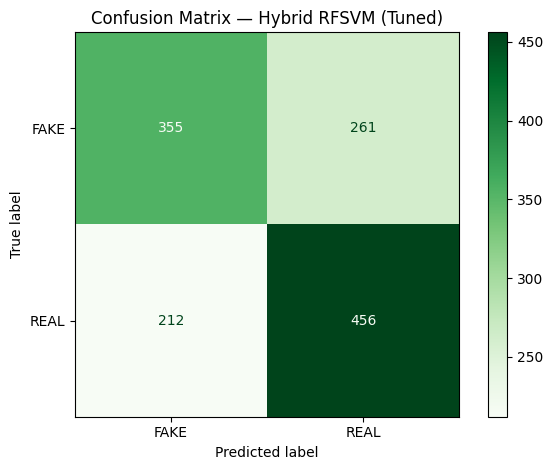

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Train Random Forest base model to get probabilities
rf_base = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_base.fit(X_train_tfidf, y_train_bin)

# 2. Get probability estimates to use as features for SVM
X_train_rf_probs = rf_base.predict_proba(X_train_tfidf)
X_val_rf_probs = rf_base.predict_proba(X_val_tfidf)

# 3. Define SVM and hyperparameter grid
svm_base = SVC(probability=True, random_state=42)
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'class_weight': ['balanced']
}

# 4. Perform Grid Search
grid_search = GridSearchCV(estimator=svm_base, param_grid=param_grid, cv=5,
                           scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train_rf_probs, y_train_bin)

# 5. Evaluate best model
best_svm = grid_search.best_estimator_
print(" Best Hyperparameters:")
print(grid_search.best_params_)

# 6. Predict on validation set
svm_preds = best_svm.predict(X_val_rf_probs)

# 7. Evaluation report
print("\n Classification Report — Hybrid RFSVM (Tuned):")
print(classification_report(y_val_bin, svm_preds, target_names=['FAKE', 'REAL']))

# 8. Confusion matrix
cm = confusion_matrix(y_val_bin, svm_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FAKE', 'REAL'])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Greens', xticks_rotation=0)
plt.title("Confusion Matrix — Hybrid RFSVM (Tuned)")
plt.grid(False)
plt.tight_layout()
plt.show()


### Deep Learning Models — Binary Fake News Classification

With our traditional models benchmarked, we now apply deep learning techniques to detect fake vs. real news in a binary setting.

We will train the following models:
1. **LSTM (Long Short-Term Memory)** — to capture sequential context.
2. **Capsule Network** — inspired by recent literature on improved feature sensitivity.
3. **BERT (Transformer-based model)** — to leverage pretrained language understanding.

These models will be trained on the same binary-labeled dataset:
- **0 = FAKE** (false, barely true, pants fire)
- **1 = REAL** (true, mostly true, half true)

Evaluation will follow the same metrics used for traditional models for fair comparison.


#### BiLSTM Model with Class Weight Balancing

In this section, we train a Bidirectional LSTM (BiLSTM) model for binary fake news classification.

- **BiLSTM** captures patterns in both forward and backward directions for better context understanding.
- **Class weights** are used to address imbalance between FAKE (0) and REAL (1) labels.
- EarlyStopping is applied to avoid overfitting.

This setup aims to improve model performance by enhancing contextual learning and reducing bias toward the majority class.



In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
import numpy as np

# Define dimensions
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128
max_length = X_train_pad.shape[1]

# Calculate class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_bin),
    y=y_train_bin
)
class_weights = dict(enumerate(weights))

# Build BiLSTM model
bilstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary output
])

# Compile model
bilstm_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

# Build the model with a defined input shape
bilstm_model.build(input_shape=(None, max_length))


# Print summary
bilstm_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 344, 128)       │     1,399,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,507,073 (5.75 MB)

 Trainable params: 1,507,073 (5.75 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# Define early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model
history = bilstm_model.fit(
    X_train_pad, y_train_bin,
    validation_data=(X_val_pad, y_val_bin),
    epochs=15,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/15
320/320 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.4977 - loss: 0.6933 - val_accuracy: 0.5607 - val_loss: 0.6907
Epoch 2/15
320/320 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5681 - loss: 0.6871 - val_accuracy: 0.5974 - val_loss: 0.6692
Epoch 3/15
320/320 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6520 - loss: 0.6425 - val_accuracy: 0.6137 - val_loss: 0.6495
Epoch 4/15
320/320 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.7214 - loss: 0.5628 - val_accuracy: 0.6090 - val_loss: 0.6678
Epoch 5/15
320/320 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.7677 - loss: 0.4954 - val_accuracy: 0.6129 - val_loss: 0.7220
Epoch 6/15
320/320 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.8126 - loss: 0.4198 - val_accuracy: 0.6020 - val_loss: 0.7756


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Classification Report — BiLSTM:
              precision    recall  f1-score   support

        FAKE       0.59      0.64      0.61       616
        REAL       0.64      0.59      0.61       668

    accuracy                           0.61      1284
   macro avg       0.61      0.61      0.61      1284
weighted avg       0.62      0.61      0.61      1284



<Figure size 600x500 with 0 Axes>

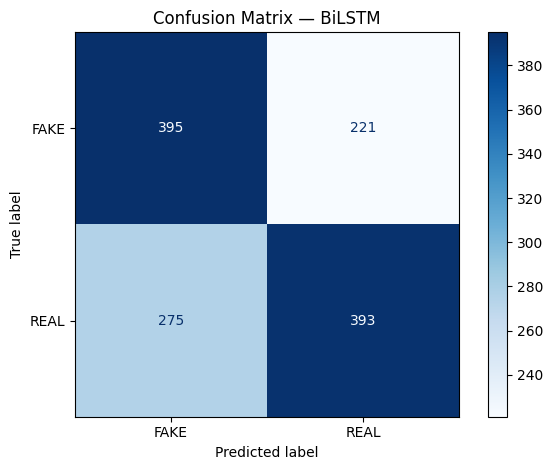

In [53]:
# Predict on validation set
y_pred_probs = bilstm_model.predict(X_val_pad)
y_pred = (y_pred_probs >= 0.5).astype(int)

# Classification report
print("Classification Report — BiLSTM:")
print(classification_report(y_val_bin, y_pred, target_names=['FAKE', 'REAL']))

# Confusion matrix
cm = confusion_matrix(y_val_bin, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FAKE', 'REAL'])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', xticks_rotation=0)
plt.title("Confusion Matrix — BiLSTM")
plt.grid(False)
plt.tight_layout()
plt.show()


#### Capsule Network for Binary Classification

Capsule Networks aim to capture hierarchical relationships between features — making them potentially useful for tasks like fake news detection, where contextual nuance and structure matter.

In this section:
- We construct a simple CapsNet architecture for binary classification.
- Input is based on padded text sequences.
- The model includes:
  - Embedding layer
  - Convolution + Primary Capsule + Dense Capsule layers
- Output is a sigmoid unit for binary prediction.

We use binary cross-entropy loss and accuracy as our evaluation metric.


In [54]:
# Download the GloVe 100d embeddings (only once)
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip


--2025-08-21 11:00:26--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-08-21 11:00:26--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-08-21 11:00:27--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [55]:
# Load GloVe 100d vectors
embedding_index = {}
with open("glove.6B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coeffs

print(f"Loaded {len(embedding_index)} word vectors.")


Loaded 400000 word vectors.


In [56]:
# Define dimensions
embedding_dim = 100  # use 100d GloVe
vocab_size = len(tokenizer.word_index) + 1  # from your tokenizer

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [57]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=max_length,  # from your padded sequence shape
    trainable=False  # freeze embeddings (or True if you want to fine-tune)
)


In [58]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K

# Squash activation function used in capsules
def squash(vectors, axis=-1):
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm)
    return scale * vectors / K.sqrt(s_squared_norm + K.epsilon())


In [59]:
from tensorflow.keras.layers import Layer

class CapsuleLayer(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings

    def build(self, input_shape):
        self.W = self.add_weight(shape=[input_shape[-1], self.num_capsule * self.dim_capsule],
                                 initializer='glorot_uniform',
                                 trainable=True,
                                 name='W')

    def call(self, inputs):
        u_hat = K.dot(inputs, self.W)
        u_hat = K.reshape(u_hat, (-1, inputs.shape[1], self.num_capsule, self.dim_capsule))
        u_hat = K.permute_dimensions(u_hat, (0, 2, 1, 3))

        b = tf.zeros_like(u_hat[:, :, :, 0])
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=1)
            o = squash(tf.reduce_sum(c[..., None] * u_hat, axis=2))
            if i < self.routings - 1:
                b += tf.reduce_sum(u_hat * o[:, :, None, :], axis=-1)
        return o


In [60]:
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Flatten

def build_capsule_model(vocab_size, embedding_dim, embedding_matrix, max_length):
    input_layer = Input(shape=(max_length,))

    # Embedding
    embedding_layer = Embedding(input_dim=vocab_size,
                                 output_dim=embedding_dim,
                                 weights=[embedding_matrix],
                                 input_length=max_length,
                                 trainable=False)(input_layer)

    # Convolutional layer for feature extraction
    conv_layer = Conv1D(filters=256, kernel_size=9, activation='relu')(embedding_layer)

    # Primary Capsule layer
    primary_caps = layers.Reshape(target_shape=[-1, 8])(conv_layer)

    # Capsule Layer
    capsule = CapsuleLayer(num_capsule=10, dim_capsule=16, routings=3)(primary_caps)
    capsule_output = Flatten()(capsule)

    # Fully connected + dropout
    dense = Dense(64, activation='relu')(capsule_output)
    dropout = Dropout(0.3)(dense)

    # Output layer
    output = Dense(1, activation='sigmoid')(dropout)

    model = models.Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [61]:
# Define early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
capsule_model = build_capsule_model(vocab_size, embedding_dim, embedding_matrix, max_length)

history = capsule_model.fit(
    X_train_pad, y_train_bin,
    validation_data=(X_val_pad, y_val_bin),
    epochs=20,
    batch_size=32,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 45s 86ms/step - accuracy: 0.5457 - loss: 0.6871 - val_accuracy: 0.5864 - val_loss: 0.6736
Epoch 2/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 46s 22ms/step - accuracy: 0.5835 - loss: 0.6718 - val_accuracy: 0.5966 - val_loss: 0.6672
Epoch 3/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.5984 - loss: 0.6648 - val_accuracy: 0.5974 - val_loss: 0.6617
Epoch 4/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.6257 - loss: 0.6374 - val_accuracy: 0.6075 - val_loss: 0.6604
Epoch 5/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6676 - loss: 0.6023 - val_accuracy: 0.6129 - val_loss: 0.6776
Epoch 6/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.7630 - loss: 0.4899 - val_accuracy: 0.5911 - val_loss: 0.7700
Epoch 7/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.8309 - loss: 0.3661 - val_accuracy: 0.5974 - val_loss: 0.8768
Epoch 8/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9138 - loss: 0.2103 - val

41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step
              precision    recall  f1-score   support

        FAKE       0.59      0.49      0.53       616
        REAL       0.59      0.69      0.64       668

    accuracy                           0.59      1284
   macro avg       0.59      0.59      0.58      1284
weighted avg       0.59      0.59      0.59      1284



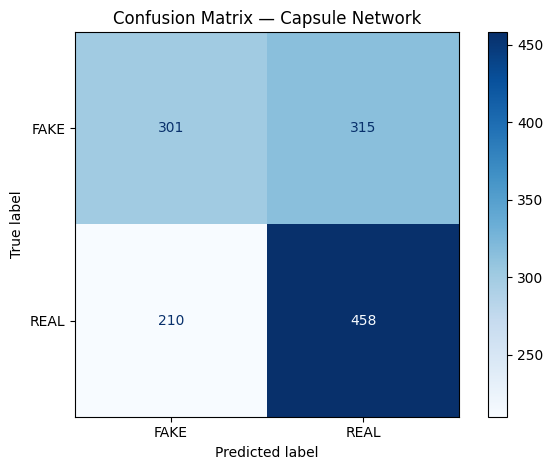

In [62]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict
y_pred = (capsule_model.predict(X_val_pad) > 0.5).astype(int)

# Metrics
print(classification_report(y_val_bin, y_pred, target_names=['FAKE', 'REAL']))

# Confusion matrix
cm = confusion_matrix(y_val_bin, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FAKE', 'REAL'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix — Capsule Network")
plt.grid(False)
plt.tight_layout()
plt.show()


#### BERT Transformer Model for Fake News Detection (Binary Classification)

In this section, we fine-tune a pre-trained BERT transformer (bert-base-uncased) for our binary classification task.

Unlike previous models, BERT requires:
- Raw text inputs (not TF-IDF)
- Tokenization using BERT's tokenizer
- Formatted tensors (input IDs, attention masks)
- Training via the HuggingFace Transformers library



In [63]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import torch

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,  # Binary classification
    output_attentions=False,
    output_hidden_states=False
)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [64]:
from transformers import BertTokenizer

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text datasets
def tokenize_data(texts, tokenizer, max_len=128):
    return tokenizer(
        list(texts),
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors='pt'
    )

train_encodings = tokenize_data(X_train, tokenizer)
val_encodings = tokenize_data(X_val, tokenizer)
test_encodings = tokenize_data(X_test, tokenizer)


In [65]:
#Create torch datasets
import torch
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    torch.tensor(y_train_bin.values)
)

val_dataset = TensorDataset(
    val_encodings['input_ids'],
    val_encodings['attention_mask'],
    torch.tensor(y_val_bin.values)
)

test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    torch.tensor(y_test_bin.values)
)


In [66]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 16

train_loader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_loader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)
test_loader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)


In [67]:
#Create a Custom Dataset Class
import torch

class FakeNewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)


In [68]:
# Convert labels to list (in case they are pandas Series)
train_labels = y_train_bin.tolist()
val_labels = y_val_bin.tolist()
test_labels = y_test_bin.tolist()

# Create datasets
train_dataset = FakeNewsDataset(train_encodings, train_labels)
val_dataset = FakeNewsDataset(val_encodings, val_labels)
test_dataset = FakeNewsDataset(test_encodings, test_labels)

# Create dataloaders
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)


In [69]:
#Define Optimizer & Training Loop Setup
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import torch

optimizer = AdamW(model.parameters(), lr=2e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [70]:
# Define Training & Evaluation Loops
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0

    for batch in dataloader:
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss / len(dataloader)
    return avg_loss

def evaluate(model, dataloader, device):
    model.eval()
    preds = []

    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            batch_preds = torch.argmax(logits, dim=1)
            preds.extend(batch_preds.cpu().numpy())

    return preds


In [71]:
# Training Loop
epochs = 3
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    train_loss = train_epoch(model, train_loader, optimizer, device)
    print(f"Training Loss: {train_loss:.4f}")



Epoch 1/3
Training Loss: 0.6713

Epoch 2/3
Training Loss: 0.6297

Epoch 3/3
Training Loss: 0.5289



Classification Report — BERT Model:
              precision    recall  f1-score   support

        FAKE       0.61      0.44      0.51       616
        REAL       0.59      0.74      0.66       668

    accuracy                           0.60      1284
   macro avg       0.60      0.59      0.58      1284
weighted avg       0.60      0.60      0.59      1284



<Figure size 600x500 with 0 Axes>

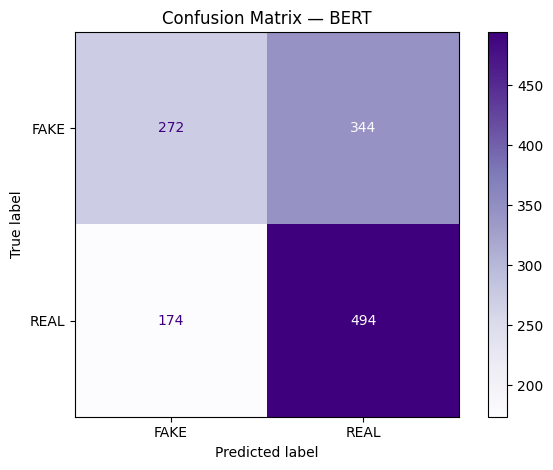

In [72]:
# After training
final_preds = evaluate(model, val_loader, device)

# Show report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("\nClassification Report — BERT Model:")
print(classification_report(y_val_bin.tolist(), final_preds, target_names=["FAKE", "REAL"]))

cm = confusion_matrix(y_val_bin.tolist(), final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["FAKE", "REAL"])

plt.figure(figsize=(6, 5))
disp.plot(cmap="Purples", xticks_rotation=0)
plt.title("Confusion Matrix — BERT")
plt.grid(False)
plt.tight_layout()
plt.show()



#### Deep Learning Model Tuning

#### Hyperparameter Tuning for BERT



In [73]:

# Define parameter grid
param_grid = {
    'learning_rate': [2e-5, 3e-5, 5e-5],
    'batch_size': [16, 32],
    'epochs': [3]
}

best_f1 = 0
best_params = None
patience = 2

def get_predictions(model, dataloader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
    return preds

In [74]:
for lr in param_grid['learning_rate']:
    for batch in param_grid['batch_size']:
        for num_epochs in param_grid['epochs']:
            print(f"\n Training with LR={lr}, Batch={batch}, Epochs={num_epochs}")

            # Reload model
            model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)
            optimizer = AdamW(model.parameters(), lr=lr)

            # Redefine dataloaders
            train_loader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch)
            val_loader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch)

            val_f1_history = []
            early_stop_triggered = False

            for epoch in range(num_epochs):
                print(f"Epoch {epoch + 1}/{num_epochs}")
                model.train()
                total_loss = 0

                for batch_data in train_loader:
                    batch_data = {k: v.to(device) for k, v in batch_data.items()}
                    outputs = model(**batch_data)
                    loss = outputs.loss
                    total_loss += loss.item()
                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()

                # Validation
                preds = get_predictions(model, val_loader, device)
                report = classification_report(y_val_bin, preds, output_dict=True)
                val_f1 = report['macro avg']['f1-score']
                print(f"Validation F1 Score: {val_f1:.4f}")

                # Early stopping check
                val_f1_history.append(val_f1)
                if len(val_f1_history) > patience:
                    if val_f1 <= max(val_f1_history[-patience - 1:-1]):
                        print("⏹Early stopping triggered.")
                        early_stop_triggered = True
                        break

            if val_f1 > best_f1:
                best_f1 = val_f1
                best_params = {
                    'learning_rate': lr,
                    'batch_size': batch,
                    'epochs': epoch + 1
                }

print("\n Best Hyperparameters:")
print(best_params)
print(f"Best Macro F1 Score: {best_f1:.4f}")


 Training with LR=2e-05, Batch=16, Epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Validation F1 Score: 0.5995
Epoch 2/3
Validation F1 Score: 0.4706
Epoch 3/3
Validation F1 Score: 0.6230

 Training with LR=2e-05, Batch=32, Epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Validation F1 Score: 0.5672
Epoch 2/3
Validation F1 Score: 0.6081
Epoch 3/3
Validation F1 Score: 0.6081

 Training with LR=3e-05, Batch=16, Epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Validation F1 Score: 0.5904
Epoch 2/3
Validation F1 Score: 0.5986
Epoch 3/3
Validation F1 Score: 0.6133

 Training with LR=3e-05, Batch=32, Epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Validation F1 Score: 0.5263
Epoch 2/3
Validation F1 Score: 0.6024
Epoch 3/3
Validation F1 Score: 0.6175

 Training with LR=5e-05, Batch=16, Epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Validation F1 Score: 0.6000
Epoch 2/3
Validation F1 Score: 0.6086
Epoch 3/3
Validation F1 Score: 0.5560
⏹Early stopping triggered.

 Training with LR=5e-05, Batch=32, Epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Validation F1 Score: 0.6079
Epoch 2/3
Validation F1 Score: 0.6204
Epoch 3/3
Validation F1 Score: 0.6000
⏹Early stopping triggered.

 Best Hyperparameters:
{'learning_rate': 2e-05, 'batch_size': 16, 'epochs': 3}
Best Macro F1 Score: 0.6230


 Classification Report — Tuned BERT:
              precision    recall  f1-score   support

        FAKE       0.57      0.76      0.65       616
        REAL       0.68      0.47      0.55       668

    accuracy                           0.61      1284
   macro avg       0.62      0.61      0.60      1284
weighted avg       0.62      0.61      0.60      1284



<Figure size 600x500 with 0 Axes>

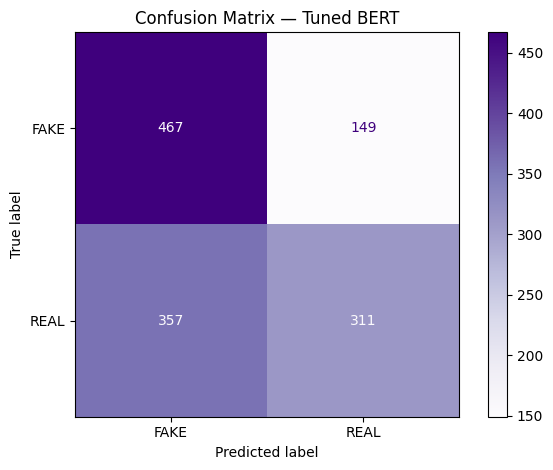

In [75]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions on validation set
model.eval()
predictions = []

with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.cpu().numpy())

# Classification report
print(" Classification Report — Tuned BERT:")
print(classification_report(y_val_bin, predictions, target_names=['FAKE', 'REAL']))

# Confusion matrix
cm = confusion_matrix(y_val_bin, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FAKE', 'REAL'])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Purples', xticks_rotation=0)
plt.title("Confusion Matrix — Tuned BERT")
plt.grid(False)
plt.tight_layout()
plt.show()



#### Hyperparameter tuning for BILSTM

In [80]:
# --- Imports ---
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

# --- 1. Tokenize and pad the text again using Keras Tokenizer ---
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)  # Your cleaned binary classification training data

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=100)
X_val_pad = pad_sequences(X_val_seq, padding='post', maxlen=100)

# --- 2. Set Class Weights ---
class_weights_array = class_weight.compute_class_weight(class_weight='balanced',
                                                        classes=np.unique(y_train_bin),
                                                        y=y_train_bin)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights_array)}

# --- 3. Define function to build BiLSTM model ---
def build_model(vocab_size, embedding_dim, lstm_units, dropout, lr):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=100),
        Bidirectional(LSTM(lstm_units, return_sequences=False)),
        Dropout(dropout),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  metrics=['accuracy'])
    return model

# --- 4. Define Hyperparameter Grid ---
param_grid = [
    {'embedding_dim': 100, 'lstm_units': 64, 'dropout': 0.3, 'lr': 0.001},
    {'embedding_dim': 100, 'lstm_units': 128, 'dropout': 0.5, 'lr': 0.0005},
    {'embedding_dim': 200, 'lstm_units': 128, 'dropout': 0.3, 'lr': 0.0001},
]

# --- 5. Train and Evaluate Each Config ---
best_f1 = 0
best_model = None
best_history = None
vocab_size = len(tokenizer.word_index) + 1

for i, params in enumerate(param_grid):
    print(f"\nTraining Config {i+1}: {params}")

    model = build_model(vocab_size, **params)

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(X_train_pad, y_train_bin,
                        validation_data=(X_val_pad, y_val_bin),
                        epochs=10,
                        batch_size=32,
                        class_weight=class_weights_dict,
                        callbacks=[early_stop],
                        verbose=1)

    # Evaluate
    val_preds = (model.predict(X_val_pad) > 0.5).astype(int)
    report = classification_report(y_val_bin, val_preds, output_dict=True)
    f1 = report['weighted avg']['f1-score']

    if f1 > best_f1:
        best_f1 = f1
        best_model = model
        best_history = history
        print(f",New Best Model Found! F1 Score: {f1:.4f}")

# --- 6. Final Evaluation ---
print("\nBest BiLSTM Model Evaluation:")
final_preds = (best_model.predict(X_val_pad) > 0.5).astype(int)
print(classification_report(y_val_bin, final_preds, target_names=["FAKE", "REAL"]))





Training Config 1: {'embedding_dim': 100, 'lstm_units': 64, 'dropout': 0.3, 'lr': 0.001}
Epoch 1/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.5336 - loss: 0.6844 - val_accuracy: 0.6199 - val_loss: 0.6491
Epoch 2/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6999 - loss: 0.5874 - val_accuracy: 0.6223 - val_loss: 0.6591
Epoch 3/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8070 - loss: 0.4267 - val_accuracy: 0.5864 - val_loss: 0.7593
Epoch 4/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8752 - loss: 0.3025 - val_accuracy: 0.5693 - val_loss: 0.8848
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
,New Best Model Found! F1 Score: 0.6201

Training Config 2: {'embedding_dim': 100, 'lstm_units': 128, 'dropout': 0.5, 'lr': 0.0005}
Epoch 1/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5111 - loss: 0.6912 - val_accuracy: 0.6075 - val_loss: 0.6579
Epoch 2/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6721 - loss: 0.6182 - val_a

<Figure size 600x500 with 0 Axes>

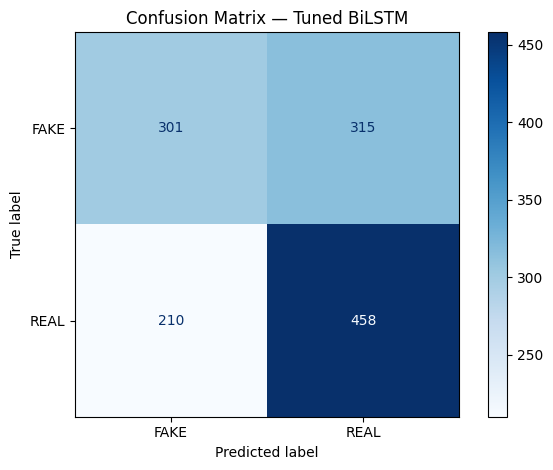

In [81]:
# Confusion Matrix
cm = confusion_matrix(y_val_bin, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FAKE', 'REAL'])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', xticks_rotation=0)
plt.title("Confusion Matrix — Tuned BiLSTM")
plt.grid(False)
plt.tight_layout()
plt.show()
